In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.special import jv, kv


In [41]:
# load unpolarized dipole data
unpolar_input_file = '/Users/brandonmanley/Desktop/PhD/rcbkdipole/build/bin/dipole_data/unpolarized_dipole_xmin0.010000_xmax0.000001.dat'
ndipole_df = pd.read_csv(unpolar_input_file, sep=r'\s+', header=None, names=['xBj', 'ln(r)', 'N[ln(r)]'])


# load polarized data
delta = 0.05
dstr = str(delta)[2:]
polar_indir = '/Users/brandonmanley/Desktop/PhD/moment_evolution/evolved_dipoles/largeNc&Nf/d'+dstr+'_ones_rc/'
polar_input_files = [polar_indir+'d'+dstr+'_NcNf3_ones_'+ia+'_rc.dat' for ia in ['Q', 'G2', 'I3', 'I4', 'I5']]
polar_data_files = [np.loadtxt(ifile) for ifile in polar_input_files]

def to_array(data_files):
    dipoles = []
    for is10, s10_row in enumerate(data_files[0]):
        for ieta, eta in enumerate(s10_row):
            dipole_values = [ifile[is10, ieta] for ifile in data_files]
            dipoles.append([(is10+1)*delta, (ieta+1)*delta] + dipole_values)
    return dipoles

pdipole_dfs = pd.DataFrame(to_array(polar_data_files), columns = ['s10', 'eta', 'Q', 'G2', 'I3', 'I4', 'I5'])


# load polarized data (w/o cutoff)
# delta = 0.1
# dstr = str(delta)[2:]
# polar_indir = '/Users/brandonmanley/Desktop/PhD/moment_evolution/evolved_dipoles/largeNc&Nf/d'+dstr+'_ones_nocutoff_rc/'
# polar_input_files = [polar_indir+'d'+dstr+'_NcNf3_ones_'+ia+'_nocutoff_rc.dat' for ia in ['Q', 'G2', 'I3', 'I4', 'I5']]
# polar_data_files = [np.loadtxt(ifile) for ifile in polar_input_files]

# delta = 0.05
# dstr = str(delta)[2:]
# polar_indir = '/Users/brandonmanley/Desktop/PhD/moment_evolution/evolved_dipoles/largeNc&Nf/d'+dstr+'_ones_nocutoff_rc/'
# polar_input_files = [polar_indir+'d'+dstr+'_NcNf3_ones_'+ia+'_nocutoff_rc.dat' for ia in ['Q', 'G2', 'I3', 'I4', 'I5']]
# polar_data_files = [np.loadtxt(ifile) for ifile in polar_input_files]

# def to_array(data_files):

#     nsteps = len(data_files[0])
#     s10_range = np.arange(-nsteps + 1, nsteps)
#     eta_range = np.arange(nsteps)
    
#     dipoles = []
#     for is10 in s10_range:
#         for ieta in eta_range:
#             if ieta > is10 and ieta < is10+nsteps: 
#                 dipoles.append([is10*delta, ieta*delta] + [idipole[is10-ieta+nsteps, ieta] for idipole in data_files])
#             else: 
#                 dipoles.append([is10*delta, ieta*delta] + [1 for idipole in data_files])
            
#     return dipoles

# pdipole_dfs = pd.DataFrame(to_array(polar_data_files), columns = ['s10', 'eta', 'Q', 'G2', 'I3', 'I4', 'I5'])


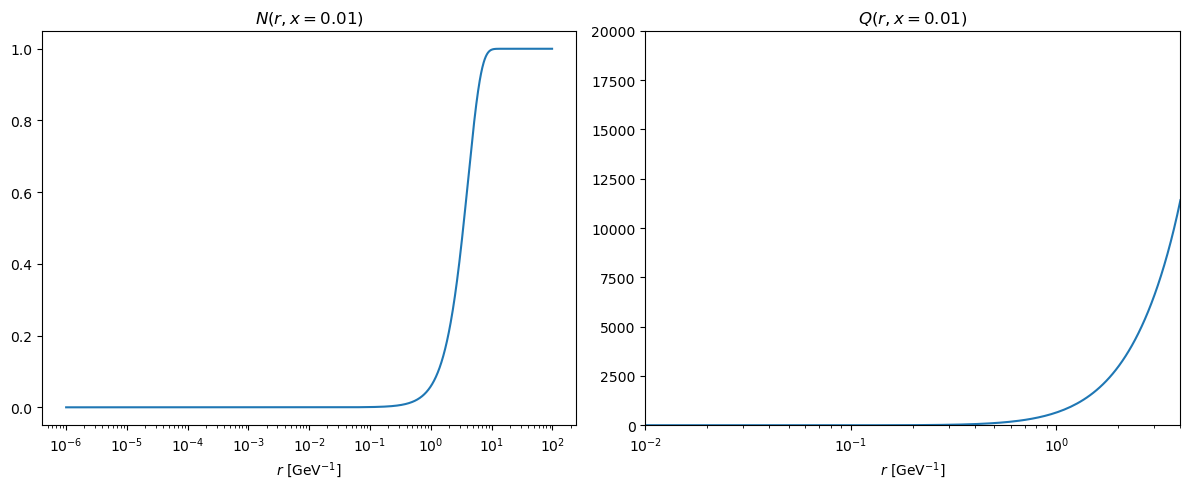

In [184]:
# to make sure we imported correctly, let's plot the dipoles as a function of r (N) and s_{10} (PDAs)

lambdaIR = 0.240  # IR cutoff in GeV

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

n_test = ndipole_df[np.isclose(ndipole_df['xBj'], 0.01, atol=1e-7)]
axes[0].plot(np.exp(n_test['ln(r)']), n_test['N[ln(r)]'])
axes[0].semilogx()
axes[0].set_xlabel(r'$r \,\, [\mathrm{GeV}^{-1}]$')
axes[0].set_title('$N(r, x=0.01)$')


bas = np.sqrt((3)/(2*np.pi))
test_eta = np.sqrt((3.0)/(2*np.pi))*np.log(10/0.01)

Q_test = pdipole_dfs[np.isclose(pdipole_dfs['eta'], test_eta, atol=delta*0.5)]
# axes[1].plot((1/lambdaIR)*np.exp(-Q_test['s10']*0.5), np.log(np.abs(Q_test['Q'])))
axes[1].plot((1/lambdaIR)*np.exp((-Q_test['s10']*0.5)/bas), Q_test['Q'])
axes[1].semilogx()
# axes[1].set_xlabel(r'$s_{10}$')
axes[1].set_xlabel(r'$r \,\, [\mathrm{GeV}^{-1}]$')
axes[1].set_title(r'$Q(r, x = 0.01)$')
axes[1].set_xlim(0.01, 4)
axes[1].set_ylim(0,20000)

plt.tight_layout()
plt.show()


In [236]:
# define the transfroms needed for DSA


# def blend(x):
#     return (1/(1+np.exp(6*x)))-0.5

def double_bessel_slow(pT, Q, z, xBj, indices, amp, lamIR = lambdaIR):

    ia, ib, ic, id = indices
    prefactor = ((pT/lamIR)**ic)*(((Q*np.sqrt(z*(1-z)))/lamIR)**id)

    # polarized dipoles
    if amp != 'N':
        bas = np.sqrt(3/(2*np.pi))
        prefactor *= (1/(2*bas))

        # select A(s_{10}, \eta = \eta(xBj))
        target_eta = round((bas/delta)*np.log((Q**2)/(xBj*(lamIR**2))))*delta
        dipole = pdipole_dfs[np.isclose(pdipole_dfs['eta'], target_eta, atol=delta*0.5)][['s10', amp]]

    # unpolarized dipole
    else:
        # select N(r, x = xBj)
        dipole = ndipole_df[np.isclose(ndipole_df['xBj'], xBj, atol=1e-7)]

    
    # riemann sum for integral over r or s_{10}
    sum = 0
    for _, irow in dipole.iterrows():

        if amp != 'N':
            u = -irow['s10']*(1/(2*bas))
            amp_value = irow[amp]
            size = delta
            if irow['s10'] < 0: amp_value = 0
  
        else: 
            u = irow['ln(r)']
            amp_value = irow['N[ln(r)]']
            if u > np.log(1/lamIR): amp_value = 0
            size = 0.01   # from evolution code

        sum += size*np.exp(u*(2+ic+id))*jv(ia, (pT/lamIR)*np.exp(u))*kv(ib, (Q/lamIR)*np.sqrt(z*(1-z))*np.exp(u))*amp_value
                         
    return prefactor*sum





def double_bessel(pT, Q, z, xBj, indices, amp, lamIR = lambdaIR):

    ia, ib, ic, id = indices
    pf = pT/lamIR
    Qf = (Q*np.sqrt(z * (1 - z)))/lamIR
    prefactor = (pf**ic)*(Qf**id)

    # Polarized dipoles
    if amp != 'N':
        bas = np.sqrt(3/(2*np.pi))
        prefactor *= (1/(2*bas))

        # Select A(s_{10}, η = η(xBj))
        target_eta = round((bas/delta) * np.log((Q**2) / (xBj*(lamIR ** 2)))) * delta
        dipole = pdipole_dfs[np.isclose(pdipole_dfs['eta'], target_eta, atol=delta * 0.5)][['s10', amp]]

        # Extract and process columns
        s10 = dipole['s10'].to_numpy()
        amp_values = dipole[amp].to_numpy()
        amp_values = np.where(s10 < 0, 0, amp_values)

        # Compute `u`
        u = -s10*(1/(2*bas))
        size = delta

    # Unpolarized dipole
    else:
        # Select N(r, x = xBj)
        dipole = ndipole_df[np.isclose(ndipole_df['xBj'], xBj, atol=1e-7)]

        # Extract and process columns
        u = dipole['ln(r)'].to_numpy()
        amp_values = 15*(dipole['N[ln(r)]'].to_numpy()) # 15 is value of \int d^2 b from fit in 
        amp_values = np.where(u > np.log(1/lamIR), 0, amp_values)
        size = 0.01  # from evolution code

    # Compute the Riemann sum in a vectorized way
    exp_term = np.exp(u*(2 + ic + id))
    jv_term = jv(ia, pf*np.exp(u))
    kv_term = kv(ib, Qf*np.exp(u))

    # Perform the sum
    total_sum = size*np.sum(exp_term * jv_term * kv_term * amp_values)

    return prefactor * total_sum
    

In [238]:
double_bessel(5, np.sqrt(5), 0.4, 0.01, [0,0,0,0], 'N')

-1.7436914502821167e-05

In [234]:
double_bessel_slow(5, np.sqrt(5), 0.4, 0.01, [0,0,0,0], 'N')

-1.1624609668547447e-06

In [75]:

pT_values = np.linspace(0.1, 10, 200)

# Measure time for the slower function
start_time = time.time()
results_slow = [double_bessel_slow(pT, np.sqrt(5), 0.4, 0.01, [0,0,0,0], 'N') for pT in pT_values]
time_slow = time.time() - start_time
print(f"Time for slower function: {time_slow:.4f} seconds")

# Measure time for the optimized function
start_time = time.time()
results_fast = [double_bessel(pT, np.sqrt(5), 0.4, 0.01, [0,0,0,0], 'N') for pT in pT_values]
time_fast = time.time() - start_time
print(f"Time for optimized function: {time_fast:.4f} seconds")

# Optional: Compare results for correctness
print(f"Results are identical: {np.allclose(results_slow, results_fast)}")

Time for slower function: 5.1695 seconds
Time for optimized function: 0.1763 seconds
Results are identical: True


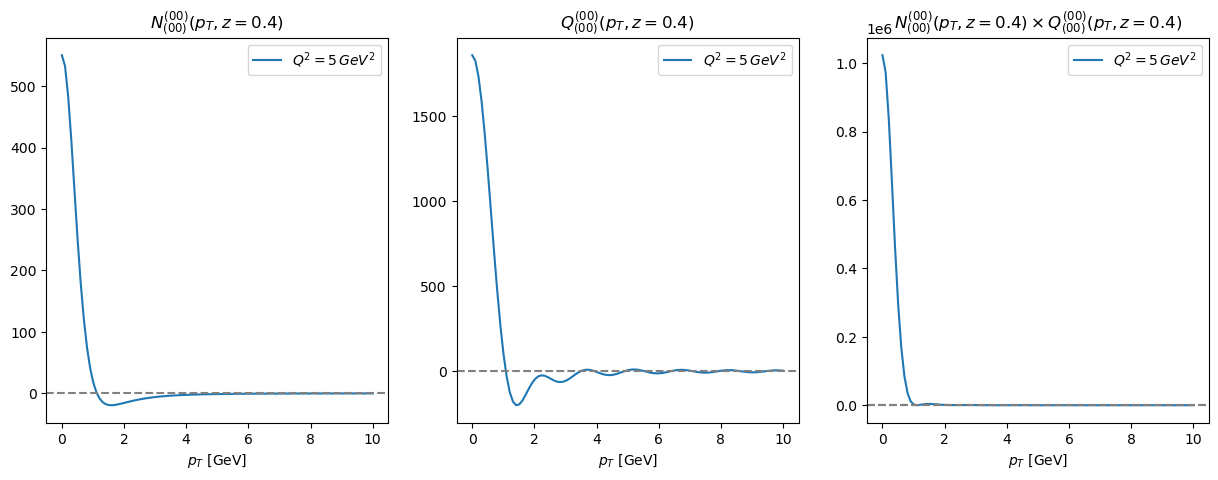

In [224]:
# compute db transform 
pT_values = np.linspace(0,10,100)
test_Q2 = np.sqrt(5)
test_z = 0.4
testN = [double_bessel(ipT, test_Q2, test_z, 0.01, [0,0,0,0], 'N') for ipT in pT_values]
testQ = [double_bessel(ipT, test_Q2, test_z, 0.01, [0,0,0,0], 'Q') for ipT in pT_values]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(pT_values, testN, label = fr'$Q^2={round(test_Q2**2)}\,GeV^2$')
axes[0].axhline(y=0, color='grey', linestyle='--')
axes[0].set_xlabel(r'$p_{T}$ [GeV]')
axes[0].set_title(fr'$N_{{(00)}}^{{(00)}}(p_T, z={test_z})$')
axes[0].legend()
# axes[0].semilogy()

axes[1].plot(pT_values, testQ, label = fr'$Q^2={round(test_Q2**2)}\,GeV^2$')
axes[1].axhline(y=0, color='grey', linestyle='--')
axes[1].set_xlabel(r'$p_{T}$ [GeV]')
axes[1].set_title(fr'$Q_{{(00)}}^{{(00)}}(p_T, z={test_z})$')
axes[1].legend()
# axes[1].semilogy()

axes[2].plot(pT_values, np.array(testN)*np.array(testQ), label = fr'$Q^2={round(test_Q2**2)}\,GeV^2$')
axes[2].axhline(y=0, color='grey', linestyle='--')
# axes[2].semilogy()
axes[2].set_xlabel(r'$p_{T}$ [GeV]')
axes[2].set_title(fr'$N_{{(00)}}^{{(00)}}(p_T, z={test_z})\times Q_{{(00)}}^{{(00)}}(p_T, z={test_z})$')
axes[2].legend()

# plt.plot(pT_values, N_pTs[1], label = "Q, a,b = 1,0")
# plt.plot(pT_values, N_pTs[2], label = "a,b = 0,1")
# plt.plot(pT_values, N_pTs[3], label = "a,b = 1,1")
# plt.legend()
plt.axhline(y=0, color='grey', linestyle='--')
plt.show()

In [240]:
# define functions needed for DSA
alpha_em = 1/137.0
Zfsq = 2/3.0
Nc = 3.0


def A_TT(pT, Q, z, xBj):

    Q_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'Q')
    G2_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'G2')
    N_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'N')

    s = (Q**2)/xBj
    prefactor = -(alpha_em*Zfsq*(Nc**2)*(Q**2)*z*(1-z))/(2*(np.pi**4)*s)

    return prefactor*((1 - 2*z)**2)*Q_11 + 2*(z**2 + (1-z)**2)*G2_11

def B_TT(pT, Q, z, xBj):
    
    Q_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'Q')
    Q_21_10 = double_bessel(pT, Q, z, xBj, [2,1,1,0], 'Q')
    
    G2_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'G2')
    G2_21_10 = double_bessel(pT, Q, z, xBj, [2,1,1,0], 'G2')
    
    I3_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I3')
    I3_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'I3')
    
    I4_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I4')
    I4_21_10 = double_bessel(pT, Q, z, xBj, [2,1,1,0], 'I4')
    I4_10_01 = double_bessel(pT, Q, z, xBj, [1,0,0,1], 'I4')
    
    I5_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I5')
    I5_10_01 = double_bessel(pT, Q, z, xBj, [1,0,0,1], 'I5')
    I5_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'I5')

    N_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'N')
    N_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'N')

    b_TT = 0.5*((1-2*z)**2)*N_01_10*Q_11
    b_TT += (z**2 + (1-z)**2)*N_01_10*G2_11 + N_11*(0.5*Q_11 + I3_11 - I3_01_10)
    b_TT += (z**2 + (1-z)**2)*N_11*(Q_21_10 + 2*G2_21_10 + I4_21_10 + I4_10_01 - I5_11 + I5_10_01 + I5_01_10)

    s = (Q**2)/xBj
    prefactor = (alpha_em*Zfsq*(Nc**2)*(Q**2)*z*(1-z))/(2*(np.pi**4)*s)

    return prefactor*(1-(2*z))*b_TT


def A_LT(pT, Q, z, xBj):
    
    Q_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'Q')
    Q_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'Q')
    
    G2_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'G2')

    N_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'N')
    N_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'N')

    s = (Q**2)/xBj
    prefactor = -(alpha_em*Zfsq*(Nc**2)*(Q**2)*((z*(1-z))**1.5))/(np.sqrt(2)*(np.pi**4)*s)

    return prefactor*(1- 2*z)*(N_00*(2*G2_11 - Q_11) - N_11*Q_00)

    
def B_LT(pT, Q, z, xBj):
    
    Q_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'Q')
    Q_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'Q')
    Q_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'Q')
    Q_10_10 = double_bessel(pT, Q, z, xBj, [1,0,1,0], 'Q')
    
    G2_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'G2')
    G2_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'G2')
    
    I3_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I3')
    I3_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'I3')
    I3_10_10 = double_bessel(pT, Q, z, xBj, [1,0,1,0], 'I3')
    
    I4_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I4')
    I4_21_10 = double_bessel(pT, Q, z, xBj, [2,1,1,0], 'I4')
    I4_10_01 = double_bessel(pT, Q, z, xBj, [1,0,0,1], 'I4')
    
    I5_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I5')
    I5_10_01 = double_bessel(pT, Q, z, xBj, [1,0,0,1], 'I5')
    I5_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'I5')

    N_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'N')
    N_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'N')
    N_10_10 = double_bessel(pT, Q, z, xBj, [1,0,1,0], 'N')
    N_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'N')

    b_LT = N_00*(I3_11 - I3_01_10)
    b_LT += N_11*I3_10_10 
    b_LT += (z**2 + (1-z)**2)*N_00*(Q_01_10 - Q_11)
    b_LT -= (z**2 + (1-z)**2)*N_11*Q_10_10 
    b_LT -= 0.5*((1- 2*z)**2)*N_10_10*Q_11
    b_LT -= 0.5*((1- 2*z)**2)*(N_11 - N_01_10)*Q_00
    b_LT += ((1- 2*z)**2)*N_00*(3*G2_11 - 2*G2_01_10 + I4_21_10 + I4_10_01 - I5_11 + I5_01_10 + I5_10_01)
    b_LT += ((1- 2*z)**2)*N_10_10*G2_11

    s = (Q**2)/xBj
    prefactor = -(alpha_em*Zfsq*(Nc**2)*(Q**2)*((z*(1-z))**1.5))/(np.sqrt(2)*(np.pi**4)*s)
    
    return prefactor*b_LT


def C_LT(pT, Q, z, xBj):
    
    Q_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'Q')
    Q_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'Q')
    
    G2_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'G2')
    G2_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'G2')
    G2_10_10 = double_bessel(pT, Q, z, xBj, [1,0,1,0], 'G2')
    
    I3_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I3')
    
    I4_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I4')
    I4_10_01 = double_bessel(pT, Q, z, xBj, [1,0,0,1], 'I4')
    I4_10_10 = double_bessel(pT, Q, z, xBj, [1,0,1,0], 'I4')
    I4_01_10 = double_bessel(pT, Q, z, xBj, [0,1,1,0], 'I4')
    I4_11_20 = double_bessel(pT, Q, z, xBj, [1,1,2,0], 'I4')
    I4_00_11 = double_bessel(pT, Q, z, xBj, [0,0,1,1], 'I4')
    I4_11_11 = double_bessel(pT, Q, z, xBj, [1,1,1,1], 'I4')
    I4_00_20 = double_bessel(pT, Q, z, xBj, [0,0,2,0], 'I4')
    
    I5_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'I5')
    I5_11_20 = double_bessel(pT, Q, z, xBj, [1,1,2,0], 'I5')
    I5_10_01 = double_bessel(pT, Q, z, xBj, [1,0,0,1], 'I5')
    I5_00_11 = double_bessel(pT, Q, z, xBj, [0,0,1,1], 'I5')
    I5_11_11 = double_bessel(pT, Q, z, xBj, [1,1,1,1], 'I5')
    I5_10_10 = double_bessel(pT, Q, z, xBj, [1,0,1,0], 'I5')
    I5_00_20 = double_bessel(pT, Q, z, xBj, [0,0,2,0], 'I5')

    N_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'N')
    N_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'N')

    c_LT = (z**2 + (1-z)**2)*N_11*Q_11
    c_LT -= N_00*I3_11
    c_LT += 0.5*((1- 2*z)**2)*N_11*Q_00
    c_LT += ((1- 2*z)**2)*N_00*(G2_01_10 - 3*G2_11 - I4_10_10 - 2*I4_11 + 2*I4_01_10 - I4_11_20 - I4_10_01 + I4_00_11 + I5_11 - I5_11_20 - I5_10_01 + I5_00_11)
    c_LT += ((1- 2*z)**2)*N_11*(G2_10_10 + I4_11_11 + I4_00_20 + I5_11_11 - I5_10_10 + I5_00_20)

    s = (Q**2)/xBj
    prefactor = -(alpha_em*Zfsq*(Nc**2)*(Q**2)*((z*(1-z))**1.5))/(np.sqrt(2)*(np.pi**4)*s)
    
    return prefactor*c_LT



# unpolarized amps
def A_TT_unpolar(pT, Q, z, xBj):
    
    N_11 = double_bessel(pT, Q, z, xBj, [1,1,0,0], 'N')
    prefactor = (4*alpha_em*Zfsq*(Nc**2)*(Q**2)*(z**2)*((1-z)**2))/((2*np.pi**4))
    
    return prefactor*(z**2 + (1-z)**2)*(N_11**2)

def A_LL_unpolar(pT, Q, z, xBj):
    
    N_00 = double_bessel(pT, Q, z, xBj, [0,0,0,0], 'N')
    prefactor = (8*alpha_em*Zfsq*(Nc**2)*(Q**2)*(z**3)*((1-z)**3))/((2*np.pi**4))
    
    return prefactor*(N_00**2)




In [250]:
# compute DSA for various kinematics
pT_values = np.linspace(1, 10, 100)

# vary Q2, xBj, z
Qs = [np.sqrt(5), np.sqrt(30), np.sqrt(35), np.sqrt(40)]
xBjs = [0.01, 0.001, 0.0001]
zs = [0.1, 0.2, 0.3, 0.4]

varied_data = {}
varied_data['Q2'] = {func.__name__: [[func(pT, Q, zs[-1], xBjs[0]) for pT in pT_values] for Q in Qs] for func in [A_TT, B_TT, A_LT, B_LT, C_LT]}
print('finished Q2')
varied_data['xBj'] = {func.__name__: [[func(pT, Qs[0], zs[-1], xBj) for pT in pT_values] for xBj in xBjs] for func in [A_TT, B_TT, A_LT, B_LT, C_LT]}
print('finished xBj')
varied_data['z'] = {func.__name__: [[func(pT, Qs[-1], z, xBjs[0]) for pT in pT_values] for z in zs] for func in [A_TT, B_TT, A_LT, B_LT, C_LT]}
print('finished z')

finished Q2
finished xBj
finished z


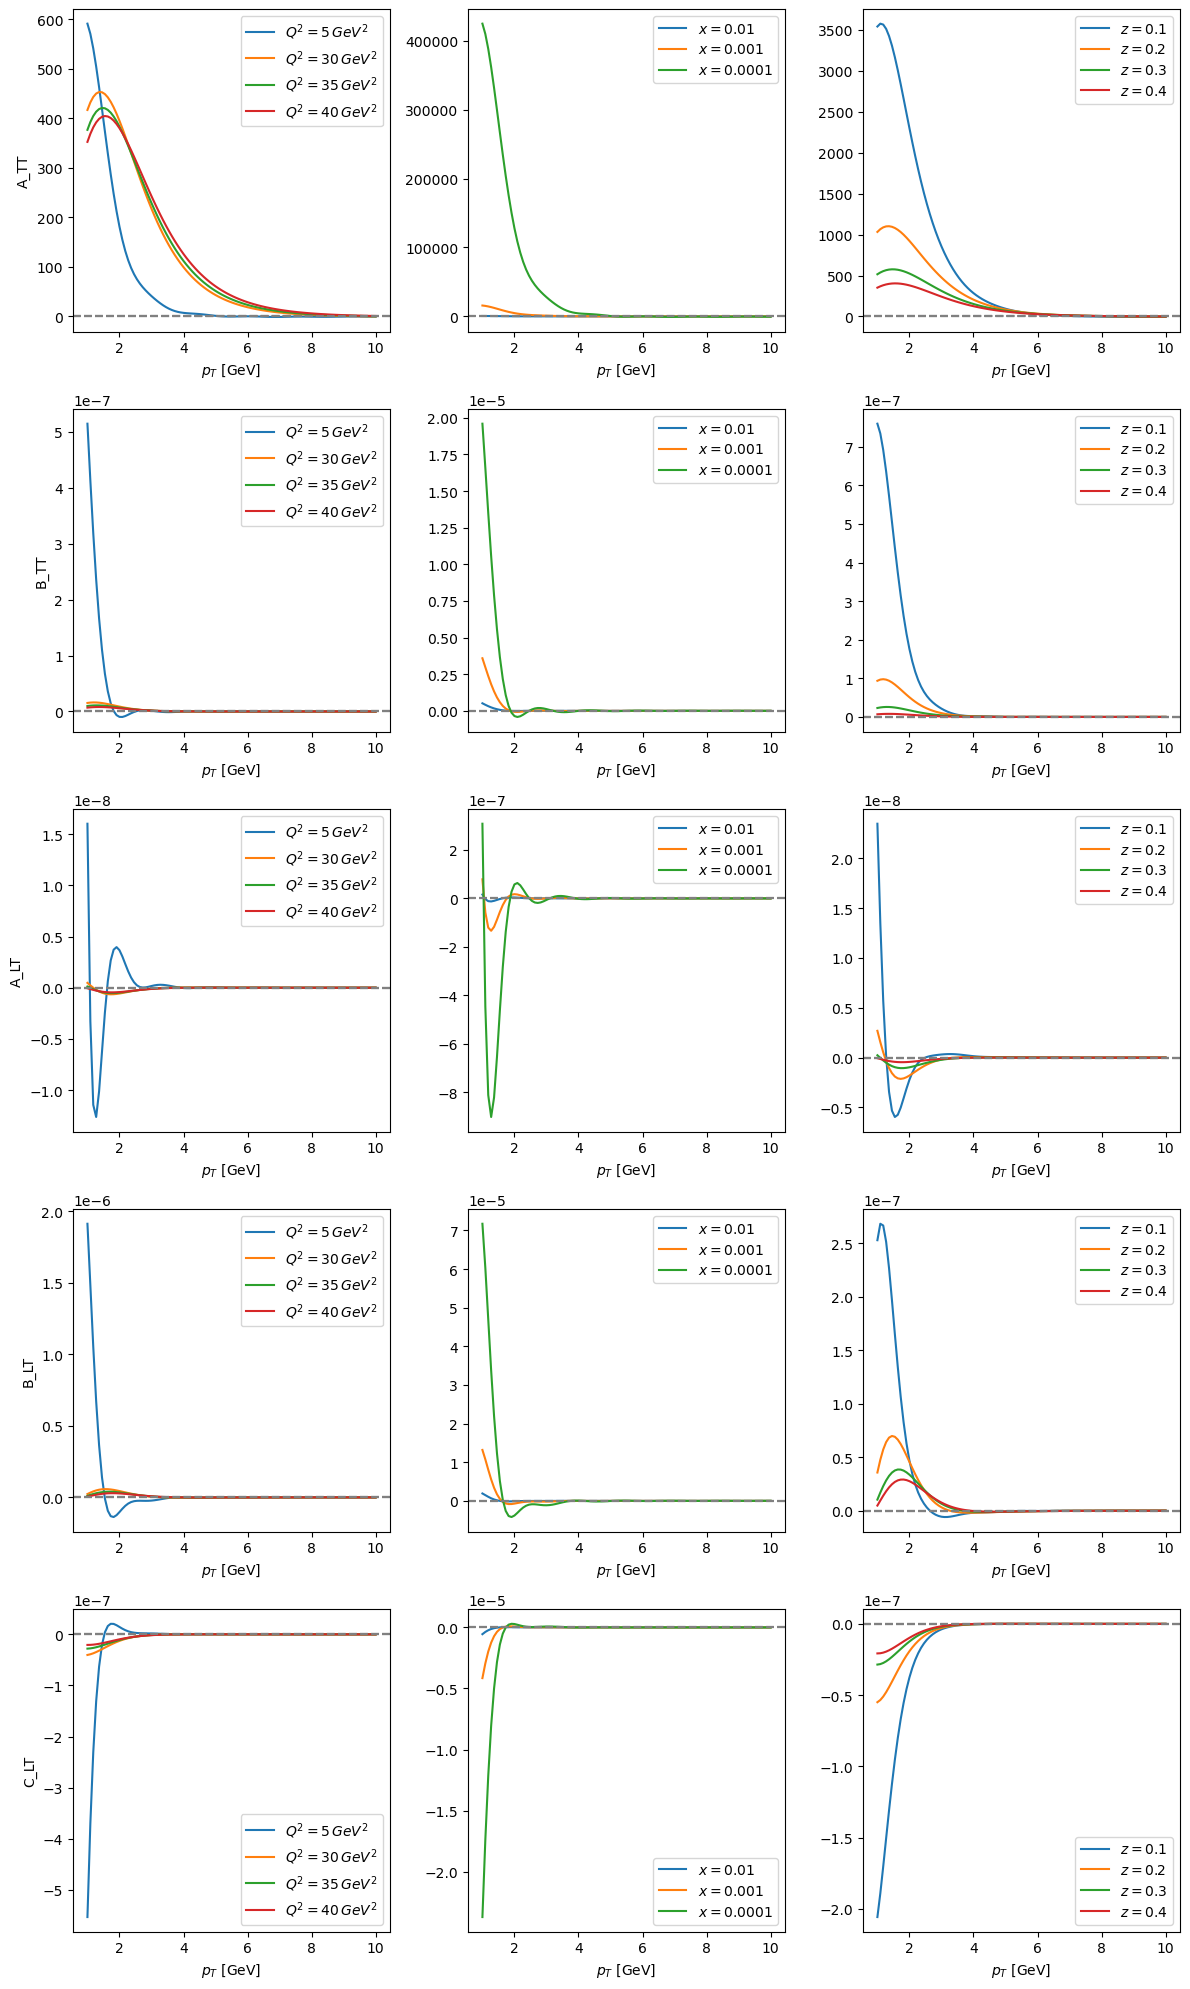

In [252]:
# plot variations

# amplitude plots
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

for idist, dist in enumerate(['A_TT', 'B_TT', 'A_LT', 'B_LT', 'C_LT']):
    axes[idist,0].set_ylabel(dist)
    
    for iQ, Q in enumerate(Qs):
        axes[idist,0].plot(pT_values, varied_data['Q2'][dist][iQ], label = fr'$Q^2={round(Q**2)}\,GeV^2$')
        axes[idist,0].legend()
        axes[idist,0].axhline(y=0, color='grey', linestyle='--')
        axes[idist,0].set_xlabel(r'$p_T$ [GeV]')
        # axes[idist,0].semilogy()

    for ixBj, xBj in enumerate(xBjs):
        axes[idist,1].plot(pT_values, varied_data['xBj'][dist][ixBj], label = fr'$x={xBj}$')
        axes[idist,1].legend()
        axes[idist,1].axhline(y=0, color='grey', linestyle='--')
        axes[idist,1].set_xlabel(r'$p_T$ [GeV]')
        # axes[idist,1].semilogy()

    for iz, z in enumerate(zs):
        axes[idist,2].plot(pT_values, varied_data['z'][dist][iz], label = fr'$z={z}$')
        axes[idist,2].legend()
        axes[idist,2].axhline(y=0, color='grey', linestyle='--')
        axes[idist,2].set_xlabel(r'$p_T$ [GeV]')
        # axes[idist,2].semilogy()


# fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# for iQ, Q in enumerate(Qs):
#     axes[iQ].plot(pT_values, np.abs(varied_data['Q2']['C_LT'][iQ]), label = fr'$C_{{LT}}(Q^2={round(Q**2)}\,GeV^2)$')
#     axes[iQ].plot(pT_values, np.abs(np.array(varied_data['Q2']['B_LT'][iQ]) - np.array(varied_data['Q2']['C_LT'][iQ])), label = fr'$B_{{LT}} - C_{{LT}}(Q^2={round(Q**2)}\,GeV^2$)')
#     axes[iQ].plot(pT_values, np.abs(np.array(varied_data['Q2']['B_TT'][iQ])), label = fr'$B_{{TT}}(Q^2={round(Q**2)}\,GeV^2)$')
#     axes[iQ].legend()
#     axes[iQ].axhline(y=0, color='grey', linestyle='--')
#     axes[iQ].set_xlabel(r'$p_T$ [GeV]')
#     axes[iQ].semilogy()


plt.tight_layout()
plt.show()



In [254]:
# compute <1> and <cos\phi> 


test_z = 0.3
test_Q2 = np.sqrt(20)
test_y = 0.8

def amom(p, Q, z, x, y, func='1'):

    if func == '1': num = (2-y)*A_TT(p, Q, z, x)
    elif func == 'cosphi': num = 0.5*(2-y)*B_TT(p, Q, z, x)
    elif func == 'cospsi': num = 0.5*np.sqrt(2*(1-y))*A_LT(p, Q, z, x)
    elif func == 'coscos': num = 0.25*np.sqrt(2*(1-y))*B_LT(p, Q, z, x)
    elif func == 'sinsin': num = 0.25*np.sqrt(2*(1-y))*C_LT(p, Q, z, x)
    denom = (1+((1-y)**2))*A_TT_unpolar(p, Q, z, x) + 4*(1-y)*A_LL_unpolar(p, Q, z, x)

    return num/denom


amoms = {ia: [[amom(ipT, Q2, test_z, 0.0001, test_y, ia) for ipT in pT_values] for Q2 in [np.sqrt(5), np.sqrt(20), np.sqrt(30), np.sqrt(40)]] for ia in ['1', 'cosphi', 'cospsi', 'coscos', 'sinsin']}



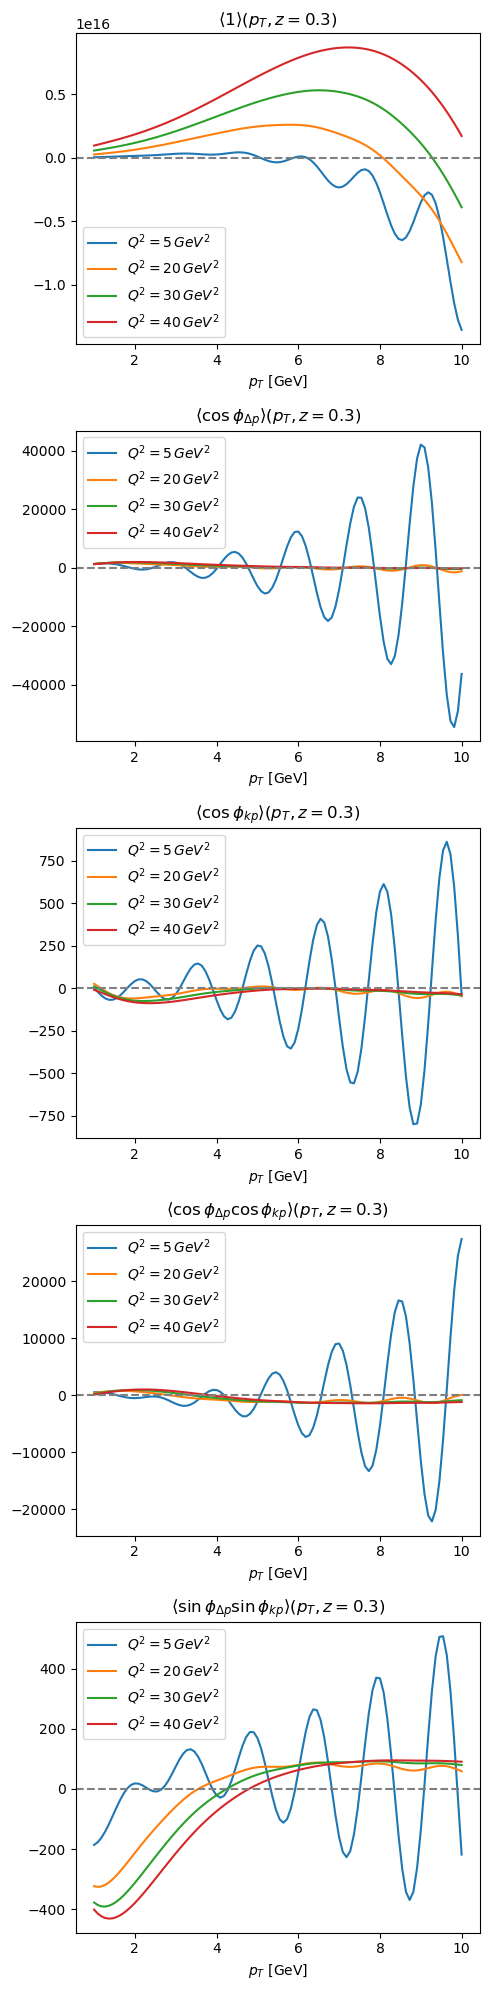

In [256]:
# plot azimuthal moments 

fig, axes = plt.subplots(5, 1, figsize=(5, 20))

for iQ, Q in enumerate([5, 20, 30, 40]):
    axes[0].plot(pT_values, amoms['1'][iQ], label = fr'$Q^2={Q}\,GeV^2$')
    axes[1].plot(pT_values, amoms['cosphi'][iQ], label = fr'$Q^2={Q}\,GeV^2$')
    axes[2].plot(pT_values, amoms['cospsi'][iQ], label = fr'$Q^2={Q}\,GeV^2$')
    axes[3].plot(pT_values, amoms['coscos'][iQ], label = fr'$Q^2={Q}\,GeV^2$')
    axes[4].plot(pT_values, amoms['sinsin'][iQ], label = fr'$Q^2={Q}\,GeV^2$')

titles = [fr'$\langle {it} \rangle (p_T, z={test_z})$' for it in ['1', '\\cos\\phi_{\\Delta p}', '\\cos\\phi_{k p}', '\\cos\\phi_{\\Delta p} \\cos\\phi_{k p}', '\\sin \\phi_{\\Delta p} \\sin \\phi_{k p}']]
for i in range(5):
    axes[i].axhline(y=0, color='grey', linestyle='--')
    axes[i].set_xlabel(r'$p_{T}$ [GeV]')
    axes[i].set_title(titles[i])
    axes[i].legend()
    # axes[i].semilogy()

# axes[1].plot(pT_values, test_cos[0], label = fr'$Q^2=20\,GeV^2$')
# axes[1].plot(pT_values, test_cos[1], label = fr'$Q^2=30\,GeV^2$')
# axes[1].plot(pT_values, test_cos[2], label = fr'$Q^2=40\,GeV^2$')
# axes[1].axhline(y=0, color='grey', linestyle='--')
# axes[1].set_xlabel(r'$p_{T}$ [GeV]')
# axes[1].set_title(fr'$\langle \cos (\phi_{{p \Delta}}) \rangle (p_T, z={test_z})$')
# axes[1].legend()
# # axes[1].semilogy()


# # plt.plot(pT_values, N_pTs[1], label = "Q, a,b = 1,0")
# # plt.plot(pT_values, N_pTs[2], label = "a,b = 0,1")
# # plt.plot(pT_values, N_pTs[3], label = "a,b = 1,1")
# # plt.legend()
# plt.axhline(y=0, color='grey', linestyle='--')
plt.tight_layout()
plt.show()